In [1]:
import numpy as np
import csv
import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib

import datasets

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
dataset_odn = datasets.C100Dataset('./dataset/cifar100_lt/data/cifar100_lt.csv')
[tr_x, tr_y, ts_x] = dataset_odn.getDataset()

spider


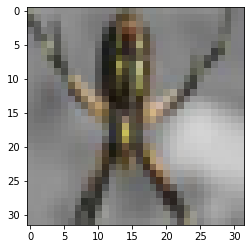

In [3]:
im_dir = './dataset/'
plt.imshow(img.imread(im_dir+tr_x[99]))
print(tr_y[99])

In [4]:
label = set(tr_y)
label = np.array(list(label))

label_dist = np.zeros(len(label))
for i,u in enumerate(tr_y):
    for j, v in enumerate(label):
        if u==v: label_dist[j] = label_dist[j]+1
label_dist = label_dist/len(tr_y)
label_dist = torch.FloatTensor(label_dist)

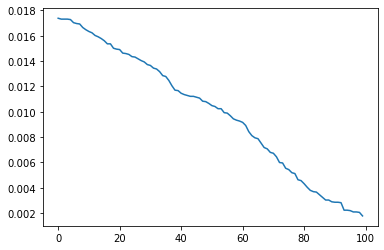

In [5]:
plt.plot(np.sort(label_dist)[::-1])

In [6]:
def tr_val(x_, y_):
    mask = np.ones(len(x_))
    mask[:int(len(mask)/5)] = 0 # #1:#0 = 4:1
    np.random.shuffle(mask)
    x_tr, x_vl = x_[mask==1], x_[mask==0]
    y_tr, y_vl = y_[mask==1], y_[mask==0]
    return x_tr, x_vl, y_tr, y_vl
def batch_div(x_, y_, num):
    x_b, y_b = [], []
    mask = np.random.randint(low=0, high=int(len(x_)/num), size=len(x_))
    for i in range (int(len(x_)/num)):
        x_b.append(x_[mask==i])
        y_b.append(y_[mask==i])
    return int(len(x_)/num), x_b, y_b

# VGGnet
<https://arxiv.org/pdf/1409.1556.pdf>
<https://arxiv.org/pdf/1512.00567.pdf>
<https://arxiv.org/pdf/1708.02002.pdf>

In [7]:
alp = 0.25
K = len(label)
trainx = np.array([img.imread(im_dir+u).T for i,u in enumerate(tr_x)])
trainy = np.ones([len(tr_y), 100], dtype='int32')*(alp/K)
for i,u in enumerate(label):
    for j,v in enumerate(tr_y):
        if v==u: trainy[j][i] += 1-alp
            
testx = np.array([img.imread(im_dir+u).T for i,u in enumerate(ts_x)])
trainx, testx = torch.FloatTensor(trainx), torch.FloatTensor(testx)
trainy = torch.FloatTensor(trainy)

In [8]:
class VGG(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.C1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.C2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.C3 = nn.Conv2d(64, 64, 3, 1, 1)
        self.C4 = nn.Conv2d(64, 128, 3, 1, 1)
        self.C5 = nn.Conv2d(128, 256, 3, 1, 1)
        self.C6 = nn.Conv2d(256, 512, 3, 1, 1)
        self.W1 = nn.Linear(512*2*2, 1024)
        self.W2 = nn.Linear(1024, 512)
        self.W3 = nn.Linear(512, 100)
        self.S = nn.Sigmoid()
        self.D = nn.Dropout(p=0.2)
        self.bn1 = torch.nn.BatchNorm2d(32)
        self.bn2 = torch.nn.BatchNorm2d(64)
        self.bn3 = torch.nn.BatchNorm2d(128)
        self.bn4 = torch.nn.BatchNorm2d(256)
        self.bn5 = torch.nn.BatchNorm2d(512)
        self.bn6 = torch.nn.BatchNorm1d(1024)
        self.bn7 = torch.nn.BatchNorm1d(512)

    def forward(self, x):
        x = self.bn1(self.C1(x))
        x = self.pool(F.relu(x))
        x = F.relu(self.bn2(self.C2(x)))
        x = self.bn2(self.C3(x))
        x = self.pool(F.relu(x))
        x = self.bn3(self.C4(x))
        x = self.bn4(self.C5(x))
        x = self.pool(F.relu(x))
        x = self.bn5(self.C6(x))
        x = self.pool(F.relu(x))
        x = x.view(-1, 512*2*2)
        x = F.relu(self.bn6(self.W1(x)))
        x = self.D(x)
        x = F.relu(self.bn7(self.W2(x)))
        x = self.D(x)
        x = self.S(self.W3(x))
        return x
    
def loss2(output, y):
    loss = F.binary_cross_entropy(output, y)
    pt = torch.exp(-loss)
    return ((1 - pt) ** gamma * loss).mean()
    

def accuracy(output, y):
    return torch.sum(torch.argmax(output, axis=1)==torch.argmax(y, axis=1))

In [9]:
reg = 0
gamma = 0.25
model = VGG()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
n_epochs = 10
x_tr, x_vl, y_tr, y_vl = tr_val(trainx, trainy)
tr_loss, vl_loss = np.zeros(n_epochs, dtype='float64'), np.zeros(n_epochs, dtype='float64')
tr_accy, vl_accy, ts_accy = np.zeros_like(tr_loss), np.zeros_like(tr_loss), np.zeros_like(tr_loss)

for epoch in range(n_epochs):
    losst = 0.
    accyt = 0
    batchnum, x_tr_b, y_tr_b = batch_div(x_tr, y_tr, 100)
    for i in range (batchnum):
        output = model.forward(x_tr_b[i])
        loss = loss2(output, y_tr_b[i])
        accy = accuracy(output, y_tr_b[i])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losst += loss.item()
        accyt += accy
    
    output2 = model.forward(x_vl)
    tr_loss[epoch] = losst
    tr_accy[epoch] = accyt
    vl_loss[epoch] = loss2(output2, y_vl).item()
    vl_accy[epoch] = accuracy(output2, y_vl)
    
    print("epoch:", epoch, "*test loss:", losst, "*val loss:", vl_loss[epoch], \
          "*tr/vl accuracy:", tr_accy[epoch]/229.79, vl_accy[epoch]/57.44)

epoch: 0 *test loss: 8.994358772411942 *val loss: 0.024772068485617638 *tr/vl accuracy: 5.89668828060403 10.880919220055711
epoch: 1 *test loss: 5.426118332892656 *val loss: 0.02261165902018547 *tr/vl accuracy: 15.501109708864616 20.891364902506965
epoch: 2 *test loss: 4.946405055001378 *val loss: 0.020757494494318962 *tr/vl accuracy: 25.806170851647156 30.2924791086351
epoch: 3 *test loss: 4.55722507275641 *val loss: 0.019548363983631134 *tr/vl accuracy: 35.10161451760303 37.221448467966574
epoch: 4 *test loss: 4.25567046739161 *val loss: 0.018826130777597427 *tr/vl accuracy: 42.71726358849384 42.009052924791085
epoch: 5 *test loss: 3.9967699740082026 *val loss: 0.01835329644382 *tr/vl accuracy: 49.89773271247661 45.33426183844011
epoch: 6 *test loss: 3.772617693990469 *val loss: 0.01817230135202408 *tr/vl accuracy: 56.39061752034466 46.08286908077994
epoch: 7 *test loss: 3.528422507457435 *val loss: 0.018032629042863846 *tr/vl accuracy: 64.18904216893685 47.64972144846797
epoch: 8 *t

KeyboardInterrupt: 

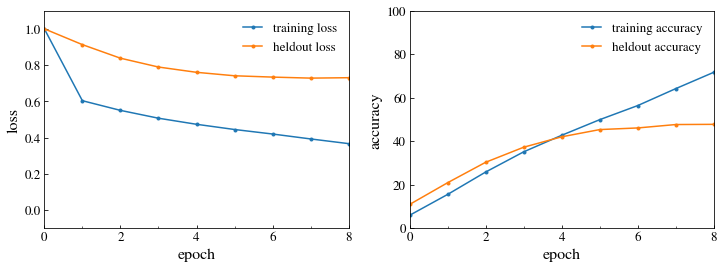

In [11]:
import matplotlib as mpl
import matplotlib.ticker as ticker
mpl.rcParams.update({
    'font.family' : 'STIXGeneral',
    'mathtext.fontset' : 'stix',
    'xtick.direction' : 'in' ,
    'xtick.labelsize' : 13 ,
    'xtick.top' : False ,
    'ytick.direction' : 'in' ,
    'ytick.labelsize' : 13 ,
    'ytick.right' : False ,
    'axes.labelsize' : 16,
    'legend.frameon' : False,
    'legend.fontsize' : 13,
    'legend.handlelength' : 1.5,
    'savefig.dpi' : 600, 
    'savefig.bbox' : 'tight'
})

fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].xaxis.set_major_locator(ticker.MultipleLocator(2))
ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(2))
ax[1].xaxis.set_minor_locator(ticker.MultipleLocator(1))

ax[0].plot(tr_loss/tr_loss[0], '.-', label='training loss')
ax[0].plot(vl_loss/vl_loss[0], '.-', label='heldout loss')
ax[0].legend()
ax[0].set_ylim(-0.1, 1.1)
ax[0].set_xlim(0, 8)
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')

ax[1].plot(tr_accy/229.79, '.-', label='training accuracy')
ax[1].plot(vl_accy/57.44, '.-', label='heldout accuracy')
ax[1].set_ylim(0, 100)
ax[1].set_xlim(0, 8)
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()


plt.savefig('vgg9.png')
plt.show()

In [10]:
def tra(x_):
    mask = np.ones(len(x_))
    #mask[:int(len(mask)/5)] = 0 # #1:#0 = 4:1
    #np.random.shuffle(mask)
    x_tr, x_vl = x_[mask==1], x_[mask==0]
    return x_tr, x_vl
a = []
b = []
x_ts, _ = tra(testx)
output = model.forward(x_ts)
for i in range(9999):
    a.append(ts_x[i].replace('_lt', ''))
b = label[torch.argmax(output, axis=1)]
a = np.array(a)
np.savetxt('cifar100ltpred_vgg9.csv', np.array([a, b]).T, fmt='%s', delimiter=',',\
          header='id,category')

In [ ]:
for i in np.random.randint(0, 9999, 10):
    plt.imshow(img.imread(im_dir+ts_x[i]))
    plt.show()
    print("pred:", b[i])

### To see images

In [ ]:
def pred_img(num):
    im_dir = './dataset/'
    plt.imshow(img.imread(im_dir+ts_x[num]))
    plt.show()
    test_x = np.array([img.imread(im_dir+u).T for i,u in enumerate(ts_x[num:num+1])])
    test_x = torch.FloatTensor(test_x)
    print("real:", ts_y[num], "pred:", label[model.forward(test_x).argmax(axis=1)])
def correct_img():
    correct_ind = []
    im_dir = './dataset/'
    for i in range (10000):
        test_x = np.array([img.imread(im_dir+u).T for j,u in enumerate(ts_x[i:i+1])])
        test_x = torch.FloatTensor(test_x)
        test_y = ts_y[i]
        output = model.forward(test_x)
        if torch.argmax(output, axis=1)==torch.argmax(testy[i]):
            correct_ind.append(i)
    return correct_ind

In [ ]:
n=0
for i in np.random.randint(0, 10000, 10):
    plt.imshow(img.imread(im_dir+ts_x[i]))
    plt.show()
    test_x = np.array([img.imread(im_dir+u).T for j,u in enumerate(ts_x[i:i+1])])
    test_x = torch.FloatTensor(test_x)
    print("pred:", label[model.forward(test_x).argmax(axis=1)])